In [1]:
import pandas as pd
import numpy as np
import requests
import json
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import joblib

# Getting the Data

In [2]:
all_listings_csv = 'sf_listings.csv'
single_family_houses_csv = 'sf_single_family_houses.csv'
townhouses_csv = 'sf_townhouses.csv'
multi_family_houses_csv = 'sf_multi_family_houses.csv'
condos_csv = 'sf_condos.csv'
apartments_csv = 'sf_apartments.csv'

all_csv = [all_listings_csv, single_family_houses_csv, townhouses_csv, multi_family_houses_csv, condos_csv]
# Read all CSV files into a single DataFrame using pd.concat()
data = pd.concat((pd.read_csv(file) for file in all_csv), ignore_index=True)

#data = pd.read_csv(all_listings_csv)
print('Num of rows:', len(data))
columns_to_keep = ['id', 'url', 'area', 'beds', 'baths' ,'price', 'status', 'county', 'status', 'homeType', 'latitude', 'longitude', 'addressRaw', 'description', 'yearBuilt', 'daysOnZillow' ]
data = data[columns_to_keep]

# Filter the data based on price range
data = data[(data['price'] > 100000) & (data['price'] < 6000000)]
# Check for duplicate rows and drop them
data.drop_duplicates(inplace=True)
data.head()

Num of rows: 3501


,id,url,area,beds,baths,price,status,county,status,homeType,latitude,longitude,addressRaw,description,yearBuilt,daysOnZillow
0,15127907,https://www.zillow.com/homedetails/49-Woodland...,1994.0,3.0,3.0,2875000,RECENTLY_SOLD,San Francisco County,RECENTLY_SOLD,SINGLE_FAMILY,37.763214,-122.45353,49 Woodland Ave,"Built in 1912, this beautiful home exudes eleg...",0.0,0
1,15132708,https://www.zillow.com/homedetails/998-Burnett...,2090.0,3.0,4.0,2000000,RECENTLY_SOLD,San Francisco County,RECENTLY_SOLD,SINGLE_FAMILY,37.747128,-122.44514,998 Burnett Ave,"Situated on large corner lot, this fully remod...",1965.0,0
2,64970228,https://www.zillow.com/homedetails/3615-20th-S...,1078.0,2.0,2.0,1102500,RECENTLY_SOLD,San Francisco County,RECENTLY_SOLD,CONDO,37.758244,-122.42171,3615 20th St APT 3,This Mission Dolores/Dolores Heights condo has...,2003.0,0
3,15111621,https://www.zillow.com/homedetails/1728-11th-A...,1439.0,2.0,1.0,1431000,RECENTLY_SOLD,San Francisco County,RECENTLY_SOLD,SINGLE_FAMILY,37.755950,-122.46757,1728 11th Ave,Rare opportunity to own a home in the highly s...,1923.0,0
4,15111786,https://www.zillow.com/homedetails/1864-9th-Av...,3567.0,5.0,5.0,3400000,RECENTLY_SOLD,San Francisco County,RECENTLY_SOLD,SINGLE_FAMILY,37.753506,-122.46525,1864 9th Ave,Breathtaking fully remodeled property located ...,1900.0,0


# Visualizing the Data

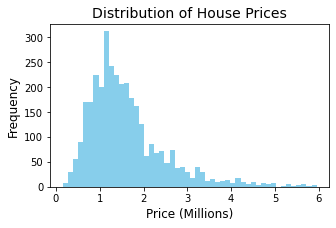

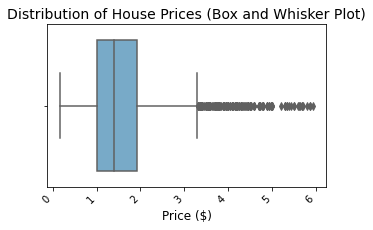

In [3]:
# Histogram of Price
prices_in_dollars = data['price']
prices_in_millions = prices_in_dollars / 1000000
plt.figure(figsize=(5, 3))
plt.hist(prices_in_millions, bins=50, color='skyblue')
plt.xlabel('Price (Millions)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of House Prices', fontsize=14)
plt.show()

# Box and whisker plot for Price
plt.figure(figsize=(5,3))
sns.boxplot(x=prices_in_millions, data=data, palette='Blues')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Price ($)', fontsize=12)
plt.title('Distribution of House Prices (Box and Whisker Plot)', fontsize=14)
plt.show()


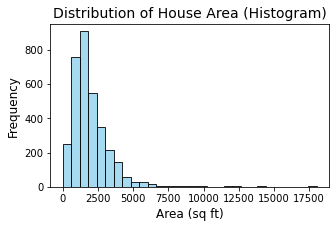

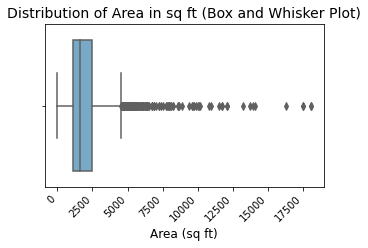

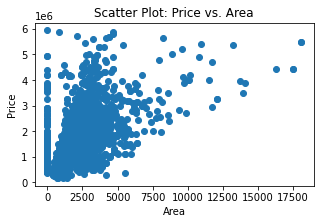

In [4]:
# Histogram of area
plt.figure(figsize=(5,3))
sns.histplot(data['area'], bins=30, color='skyblue')
plt.xlabel('Area (sq ft)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of House Area (Histogram)', fontsize=14)
plt.show()

# Box and whisker plot for area
plt.figure(figsize=(5,3))
sns.boxplot(x='area', data=data, palette='Blues')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Area (sq ft)', fontsize=12)
plt.title('Distribution of Area in sq ft (Box and Whisker Plot)', fontsize=14)
plt.show()

# Scatter plot for 'price' against 'area'
plt.figure(figsize=(5,3))
plt.scatter(data['area'], data['price'])
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Scatter Plot: Price vs. Area')
plt.show()

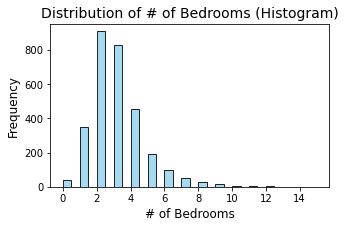

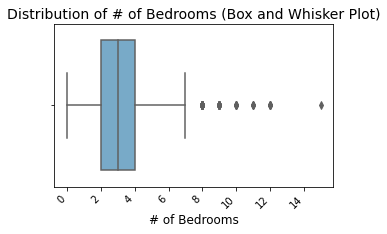

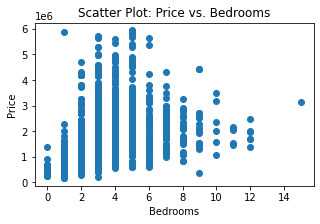

In [5]:
# Histogram of # of bedrooms
plt.figure(figsize=(5,3))
sns.histplot(data['beds'], bins=30, color='skyblue')
plt.xlabel('# of Bedrooms', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of # of Bedrooms (Histogram)', fontsize=14)
plt.show()

# Box and whisker plot for # of bedrooms
plt.figure(figsize=(5,3))
sns.boxplot(x='beds', data=data, palette='Blues')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('# of Bedrooms', fontsize=12)
plt.title('Distribution of # of Bedrooms (Box and Whisker Plot)', fontsize=14)
plt.show()

# Scatter plot for 'price' against bedrooms
plt.figure(figsize=(5,3))
plt.scatter(data['beds'], data['price'])
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.title('Scatter Plot: Price vs. Bedrooms')
plt.show()

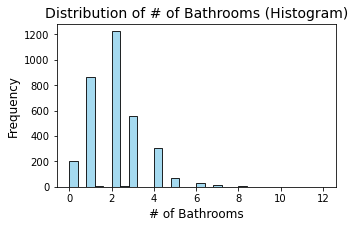

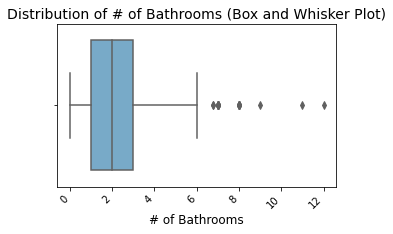

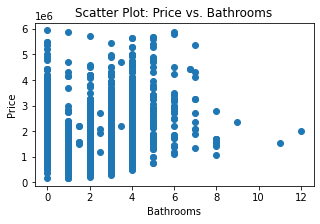

In [6]:
# Histogram of # of bathrooms
plt.figure(figsize=(5,3))
sns.histplot(data['baths'], bins=30, color='skyblue')
plt.xlabel('# of Bathrooms', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of # of Bathrooms (Histogram)', fontsize=14)
plt.show()

# Box and whisker plot for # of bathrooms
plt.figure(figsize=(5,3))
sns.boxplot(x='baths', data=data, palette='Blues')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('# of Bathrooms', fontsize=12)
plt.title('Distribution of # of Bathrooms (Box and Whisker Plot)', fontsize=14)
plt.show()

# Scatter plot for 'price' against bathrooms
plt.figure(figsize=(5,3))
plt.scatter(data['baths'], data['price'])
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.title('Scatter Plot: Price vs. Bathrooms')
plt.show()

Data is clearly to skewed to the right with some outliers. This means that most of the data is centered in the left side.

# Identifying Outliers

In [7]:
#Fills the missing values in the 'yearBuilt' column with the median value
data['yearBuilt'] = data['yearBuilt'].replace(0, float('nan'))  
data['yearBuilt'] = data['yearBuilt'].fillna(data['yearBuilt'].median())

# Drop row if 'description' column is empty
data.dropna(subset=['description', 'price'], inplace=True)

# Drop rows where 'area', 'beds', or 'bath' is 0 or NaN in one line
#data = data.dropna(subset=['area', 'beds', 'baths', 'price']).loc[lambda x: (x['area'] != 0) & (x['beds'] != 0) & (x['baths'] != 0) & (x['price'] != 0)]

# Calculate the mean for each column
price_mean = data['price'].mean()
area_mean = data['area'].mean()
beds_mean = data['beds'].mean()
baths_mean = data['baths'].mean()

# Replace the 0 and NaN values in 'area' with the mean value
data['price'] = data['price'].replace({0: price_mean, np.nan: price_mean})
data['area'] = data['area'].replace({0: area_mean, np.nan: area_mean})
data['beds'] = data['beds'].replace({0: beds_mean, np.nan: beds_mean})
data['baths'] = data['baths'].replace({0: baths_mean, np.nan: baths_mean})

In [8]:
# Z-Score method to identify outliers
def z_score_outliers(data, threshold=2):
    mean = data.mean()
    std_dev = data.std()
    z_scores = (data - mean) / std_dev
    return data[abs(z_scores) > threshold]

# IQR method to identify outliers
def iqr_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data < lower_bound) | (data > upper_bound)]

In [9]:
# Handling outliers for the 'price' column
price_outliers_zscore = z_score_outliers(data['price'])
price_outliers_iqr = iqr_outliers(data['price'])
print("Price Outliers using Z-Score:", price_outliers_zscore)
print("Price Outliers using IQR:", price_outliers_iqr)

# Handling outliers for the 'area' column
area_outliers_zscore = z_score_outliers(data['area'])
area_outliers_iqr = iqr_outliers(data['area'])
print("Area Outliers using Z-Score:", area_outliers_zscore)
print("Area Outliers using IQR:", area_outliers_iqr)

# Handling outliers for the 'beds' column
beds_outliers_zscore = z_score_outliers(data['beds'])
beds_outliers_iqr = iqr_outliers(data['beds'])
print("Bedrooms Outliers using Z-Score:", beds_outliers_zscore)
print("Bedrooms Outliers using IQR:", beds_outliers_iqr)

# Handling outliers for the 'baths' column
baths_outliers_zscore = z_score_outliers(data['baths'])
baths_outliers_iqr = iqr_outliers(data['baths'])
print("Bathrooms Outliers using Z-Score:", baths_outliers_zscore)
print("Bathrooms Outliers using IQR:", baths_outliers_iqr)


Price Outliers using Z-Score: 4       3400000
14      3800000
184     4935937
200     5700000
209     4600000
         ...   
3387    5450000
3390    3500000
3481    3950000
3484    3600000
3498    5875000
Name: price, Length: 163, dtype: int64
Price Outliers using IQR: 4       3400000
14      3800000
184     4935937
200     5700000
209     4600000
         ...   
3439    3300000
3444    3300000
3481    3950000
3484    3600000
3498    5875000
Name: price, Length: 181, dtype: int64
Area Outliers using Z-Score: 174      6741.0
273      5898.0
520      5625.0
581     18050.0
604      5500.0
         ...   
2671     6912.0
2672     5666.0
2673     5475.0
2676     6222.0
3481     5332.0
Name: area, Length: 110, dtype: float64
Area Outliers using IQR: 126     4657.0
174     6741.0
200     4390.0
273     5898.0
315     4950.0
         ...  
2671    6912.0
2672    5666.0
2673    5475.0
2676    6222.0
3481    5332.0
Name: area, Length: 165, dtype: float64
Bedrooms Outliers using Z-Score: 12    

In [10]:
# Combine both methods to identify potential outliers for each column
potential_outliers_price = price_outliers_zscore.index.intersection(price_outliers_iqr.index)
potential_outliers_area = area_outliers_zscore.index.intersection(area_outliers_iqr.index)
potential_outliers_beds = beds_outliers_zscore.index.intersection(beds_outliers_iqr.index)
potential_outliers_baths = baths_outliers_zscore.index.intersection(baths_outliers_iqr.index)

# Find all the indices of potential outliers for all columns
all_potential_outliers = (
    potential_outliers_price.union(potential_outliers_area)
    .union(potential_outliers_beds)
    .union(potential_outliers_baths)
)

# Remove potential outliers from the data
data_clean = data.drop(all_potential_outliers)

print(data_clean.head())
print('Num of rows:', len(data_clean))

         id                                                url    area  beds  \
0  15127907  https://www.zillow.com/homedetails/49-Woodland...  1994.0   3.0   
1  15132708  https://www.zillow.com/homedetails/998-Burnett...  2090.0   3.0   
2  64970228  https://www.zillow.com/homedetails/3615-20th-S...  1078.0   2.0   
3  15111621  https://www.zillow.com/homedetails/1728-11th-A...  1439.0   2.0   
5  15196831  https://www.zillow.com/homedetails/160-Eucalyp...  1390.0   2.0   

   baths    price         status                county         status  \
0    3.0  2875000  RECENTLY_SOLD  San Francisco County  RECENTLY_SOLD   
1    4.0  2000000  RECENTLY_SOLD  San Francisco County  RECENTLY_SOLD   
2    2.0  1102500  RECENTLY_SOLD  San Francisco County  RECENTLY_SOLD   
3    1.0  1431000  RECENTLY_SOLD  San Francisco County  RECENTLY_SOLD   
5    1.0  1325000  RECENTLY_SOLD  San Francisco County  RECENTLY_SOLD   

        homeType   latitude  longitude          addressRaw  \
0  SINGLE_FAMILY  

# Visualizing the Data after Dropping Outliers

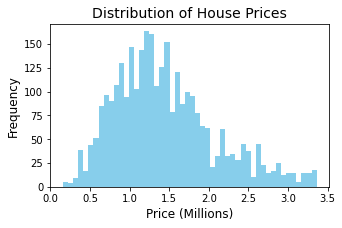

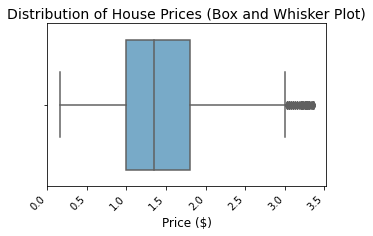

In [11]:
# Histogram of Price
prices_in_dollars = data_clean['price']
prices_in_millions = prices_in_dollars / 1000000
plt.figure(figsize=(5, 3))
plt.hist(prices_in_millions, bins=50, color='skyblue')
plt.xlabel('Price (Millions)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of House Prices', fontsize=14)
plt.show()

# Box and whisker plot for Price
plt.figure(figsize=(5,3))
sns.boxplot(x=prices_in_millions, data=data, palette='Blues')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Price ($)', fontsize=12)
plt.title('Distribution of House Prices (Box and Whisker Plot)', fontsize=14)
plt.show()


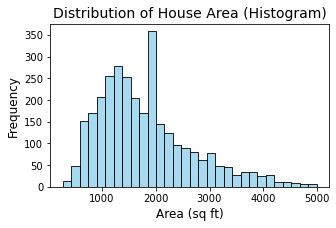

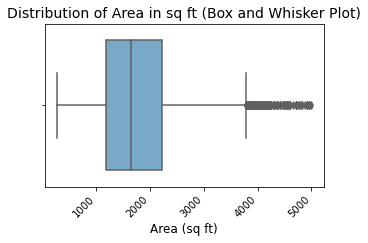

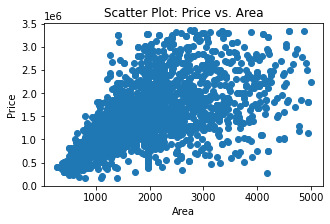

In [12]:
# Histogram of area
plt.figure(figsize=(5,3))
sns.histplot(data_clean['area'], bins=30, color='skyblue')
plt.xlabel('Area (sq ft)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of House Area (Histogram)', fontsize=14)
plt.show()

# Box and whisker plot for area
plt.figure(figsize=(5,3))
sns.boxplot(x='area', data=data_clean, palette='Blues')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Area (sq ft)', fontsize=12)
plt.title('Distribution of Area in sq ft (Box and Whisker Plot)', fontsize=14)
plt.show()

# Scatter plot for 'price' against 'area'
plt.figure(figsize=(5,3))
plt.scatter(data_clean['area'], data_clean['price'])
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Scatter Plot: Price vs. Area')
plt.show()

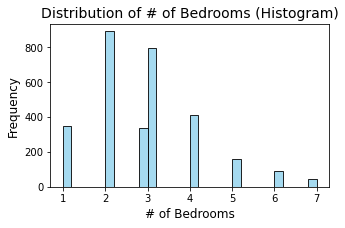

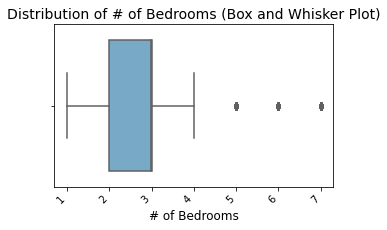

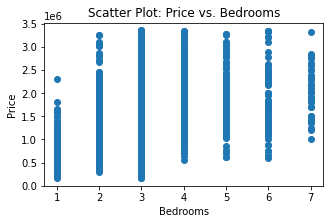

In [13]:
# Histogram of # of bedrooms
plt.figure(figsize=(5,3))
sns.histplot(data_clean['beds'], bins=30, color='skyblue')
plt.xlabel('# of Bedrooms', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of # of Bedrooms (Histogram)', fontsize=14)
plt.show()

# Box and whisker plot for # of bedrooms
plt.figure(figsize=(5,3))
sns.boxplot(x='beds', data=data_clean, palette='Blues')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('# of Bedrooms', fontsize=12)
plt.title('Distribution of # of Bedrooms (Box and Whisker Plot)', fontsize=14)
plt.show()

# Scatter plot for 'price' against bedrooms
plt.figure(figsize=(5,3))
plt.scatter(data_clean['beds'], data_clean['price'])
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.title('Scatter Plot: Price vs. Bedrooms')
plt.show()

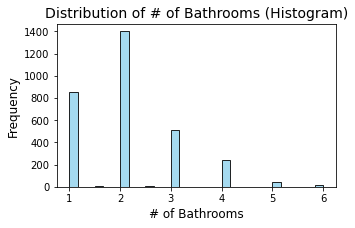

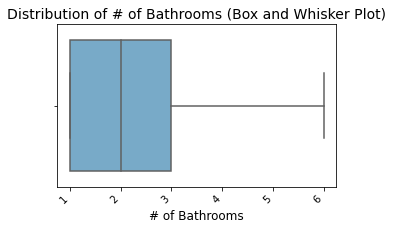

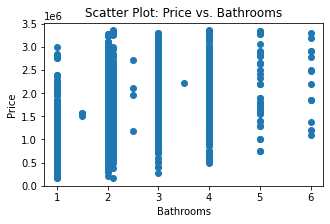

In [14]:
# Histogram of # of bathrooms
plt.figure(figsize=(5,3))
sns.histplot(data_clean['baths'], bins=30, color='skyblue')
plt.xlabel('# of Bathrooms', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of # of Bathrooms (Histogram)', fontsize=14)
plt.show()

# Box and whisker plot for # of bathrooms
plt.figure(figsize=(5,3))
sns.boxplot(x='baths', data=data_clean, palette='Blues')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('# of Bathrooms', fontsize=12)
plt.title('Distribution of # of Bathrooms (Box and Whisker Plot)', fontsize=14)
plt.show()

# Scatter plot for 'price' against bathrooms
plt.figure(figsize=(5,3))
plt.scatter(data_clean['baths'], data_clean['price'])
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.title('Scatter Plot: Price vs. Bathrooms')
plt.show()

For all of the diagrams, we can see that there is a decrease in skewness.

# Description Data Preprocessing 

In [15]:
# Lowercase, Tokenize, Remove stop words, Lemmatize the data
def preprocess_text(description):
    # Check if the text is a string, if not, convert to an empty string
    if isinstance(description, str):
        # Convert description to lowercase
        description = description.lower()
        
        # Tokenization
        words = nltk.word_tokenize(description)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        
        # Remove numbers
        words = [word for word in words if not re.match(r'^-?[0-9]+$', word)]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        # Remove punctuation
        words = [word for word in words if word not in string.punctuation]

        return words
    else:
        return []

data_clean['processed_description'] = data_clean['description'].apply(preprocess_text)
print(data_clean['processed_description'])
print(len(data_clean))


0       [built, beautiful, home, exudes, elegance, tru...
1       [situated, large, corner, lot, fully, remodele...
2       [mission, dolores/dolores, height, condo, bedr...
3       [rare, opportunity, home, highly, sought-after...
5       [incredible, location, first, time, market, ye...
                              ...                        
3495    [bryant, st, apt, san, francisco, ca, condo, h...
3496    [jefferson, st, spacious, house-like, condo, r...
3497    [welcome, expansive, bedroom, 1.5, bath, full-...
3499    [well-located, top-floor, condominium, offer, ...
3500    [bedroom, office, historic, coveted, union, te...
Name: processed_description, Length: 3074, dtype: object
3074


# TF-IDF (Term Frequency-Inverse Document Frequency)

In [16]:
list_strings = data_clean['processed_description'].tolist()
sentences = [' '.join(doc) for doc in list_strings]

# Function to extract TF-IDF features
def extract_tfidf_features(data):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data)
    return pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df = extract_tfidf_features(sentences)

print(tfidf_df.head())

    00  000  000sf  000sqft  001  004  005  009  00pm   01  ...  zip  zipcar  \
0  0.0  0.0    0.0      0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
1  0.0  0.0    0.0      0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
2  0.0  0.0    0.0      0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
3  0.0  0.0    0.0      0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
4  0.0  0.0    0.0      0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   

   zline  zone  zoned  zoning  zoo  zoom  zuckerberg  zuni  
0    0.0   0.0    0.0     0.0  0.0   0.0         0.0   0.0  
1    0.0   0.0    0.0     0.0  0.0   0.0         0.0   0.0  
2    0.0   0.0    0.0     0.0  0.0   0.0         0.0   0.0  
3    0.0   0.0    0.0     0.0  0.0   0.0         0.0   0.0  
4    0.0   0.0    0.0     0.0  0.0   0.0         0.0   0.0  

[5 rows x 8601 columns]


# Bag of Words

In [17]:
# Function to extract Bag of Words features
def extract_bow_features(data):
    bow_vectorizer = CountVectorizer()
    bow_matrix = bow_vectorizer.fit_transform(data)
    return pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())

bow_df = extract_bow_features(sentences)

print(bow_df)

      00  000  000sf  000sqft  001  004  005  009  00pm  01  ...  zip  zipcar  \
0      0    0      0        0    0    0    0    0     0   0  ...    0       0   
1      0    0      0        0    0    0    0    0     0   0  ...    0       0   
2      0    0      0        0    0    0    0    0     0   0  ...    0       0   
3      0    0      0        0    0    0    0    0     0   0  ...    0       0   
4      0    0      0        0    0    0    0    0     0   0  ...    0       0   
...   ..  ...    ...      ...  ...  ...  ...  ...   ...  ..  ...  ...     ...   
3069   0    1      0        0    0    0    0    0     0   0  ...    0       0   
3070   0    0      0        0    0    0    0    0     0   0  ...    0       0   
3071   0    0      0        0    0    0    0    0     0   0  ...    0       0   
3072   0    0      0        0    0    0    0    0     0   0  ...    0       0   
3073   0    0      0        0    0    0    0    0     0   0  ...    0       0   

      zline  zone  zoned  z

# N-Grams


In [18]:
# Create a new DataFrame for n-grams
ngram_df = data_clean[['processed_description']].copy()

# Generates n-grams from a list of words
def generate_ngrams(words, n):
    return list(ngrams(words, n))

# Generate n-grams for each description in the DataFrame
ngram_df['unigrams'] = ngram_df['processed_description'].apply(lambda desc: generate_ngrams(desc, 1))
ngram_df['bigrams'] = ngram_df['processed_description'].apply(lambda desc: generate_ngrams(desc, 2))
ngram_df[f'trigrams'] = ngram_df['processed_description'].apply(lambda desc: generate_ngrams(desc, 3))

# Display the DataFrame with processed descriptions and their corresponding n-grams
print(ngram_df.head())
print(len(ngram_df))

                               processed_description  \
0  [built, beautiful, home, exudes, elegance, tru...   
1  [situated, large, corner, lot, fully, remodele...   
2  [mission, dolores/dolores, height, condo, bedr...   
3  [rare, opportunity, home, highly, sought-after...   
5  [incredible, location, first, time, market, ye...   

                                            unigrams  \
0  [(built,), (beautiful,), (home,), (exudes,), (...   
1  [(situated,), (large,), (corner,), (lot,), (fu...   
2  [(mission,), (dolores/dolores,), (height,), (c...   
3  [(rare,), (opportunity,), (home,), (highly,), ...   
5  [(incredible,), (location,), (first,), (time,)...   

                                             bigrams  \
0  [(built, beautiful), (beautiful, home), (home,...   
1  [(situated, large), (large, corner), (corner, ...   
2  [(mission, dolores/dolores), (dolores/dolores,...   
3  [(rare, opportunity), (opportunity, home), (ho...   
5  [(incredible, location), (location, first),

# Word Embedding

In [19]:
# Word Embedding is a vector representation of a meaning of a word

# Function to train Word2Vec model and generate word embeddings
def generate_word_embeddings(list_strings, embedding_dim=100):
    model = Word2Vec(list_strings, size=embedding_dim, window=5, min_count=2, sg=1, workers=4)
    
    word_embeddings_list = []
    for sentence in list_strings:
        embeddings = [model.wv[word] for word in sentence if word in model.wv]
        if embeddings:
            sentence_embedding = sum(embeddings) / len(embeddings)
        else:
            sentence_embedding = [0] * embedding_dim
        word_embeddings_list.append(sentence_embedding)
    
    word_embeddings_df = pd.DataFrame(word_embeddings_list)
    return word_embeddings_df

word_embeddings_df = generate_word_embeddings(list_strings)
print(word_embeddings_df)


            0         1         2         3         4         5         6   \
0     0.326766  0.039202  0.180480 -0.340191  0.095769  0.021740 -0.210667   
1     0.311923  0.041749  0.173994 -0.297958  0.145549  0.082498 -0.211533   
2     0.353257  0.028678  0.159532 -0.343439  0.090050  0.051892 -0.209697   
3     0.265326 -0.016853  0.034792 -0.260742  0.000601 -0.103087 -0.158908   
4     0.292195 -0.012902  0.083028 -0.252096  0.028225 -0.019404 -0.202398   
...        ...       ...       ...       ...       ...       ...       ...   
3069  0.387033  0.082880  0.095934 -0.624561 -0.413496  0.179303 -0.515596   
3070  0.289016  0.024985  0.166839 -0.316483  0.098373  0.031570 -0.193065   
3071  0.322107  0.010739  0.184641 -0.320186  0.038454 -0.010258 -0.203684   
3072  0.301263  0.055494  0.205149 -0.322402  0.051155  0.024149 -0.178683   
3073  0.378172 -0.035007  0.134048 -0.352828 -0.056047 -0.035821 -0.160313   

            7         8         9   ...        90        91    

# Final Steps Before Models

In [20]:
# Reset the indices of the individual DataFrames
data_clean.reset_index(drop=True, inplace=True)
tfidf_df.reset_index(drop=True, inplace=True)
bow_df.reset_index(drop=True, inplace=True)
ngram_df.reset_index(drop=True, inplace=True)
word_embeddings_df.reset_index(drop=True, inplace=True)

# Perform one-hot encoding on the 'hometype' column
one_hot_hometype = pd.get_dummies(data_clean['homeType'], prefix='homeType', drop_first=True)

# Add a prefix to the column names of each DataFrame to make them unique
word_embeddings_df.columns = 'emb_' + word_embeddings_df.columns.astype(str)
tfidf_df.columns = 'tfidf_' + tfidf_df.columns.astype(str)
bow_df.columns = 'bow_' + bow_df.columns.astype(str)

# Combine all the features into a single DataFrame with unique column names
combined_data = pd.concat([data_clean[['beds', 'baths', 'area', 'yearBuilt']], word_embeddings_df, tfidf_df, bow_df], axis=1)
print(combined_data.head())

# Convert all column names to strings
combined_data.columns = combined_data.columns.astype(str)

# X are the features and y is the target variable
X = combined_data
y = data_clean['price']

# Split the data into training and testing sets (e.g., 80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


   beds  baths    area  yearBuilt     emb_0     emb_1     emb_2     emb_3  \
0   3.0    3.0  1994.0     1931.0  0.326766  0.039202  0.180480 -0.340191   
1   3.0    4.0  2090.0     1965.0  0.311923  0.041749  0.173994 -0.297958   
2   2.0    2.0  1078.0     2003.0  0.353257  0.028678  0.159532 -0.343439   
3   2.0    1.0  1439.0     1923.0  0.265326 -0.016853  0.034792 -0.260742   
4   2.0    1.0  1390.0     1939.0  0.292195 -0.012902  0.083028 -0.252096   

      emb_4     emb_5  ...  bow_zip  bow_zipcar  bow_zline  bow_zone  \
0  0.095769  0.021740  ...        0           0          0         0   
1  0.145549  0.082498  ...        0           0          0         0   
2  0.090050  0.051892  ...        0           0          0         0   
3  0.000601 -0.103087  ...        0           0          0         0   
4  0.028225 -0.019404  ...        0           0          0         0   

   bow_zoned  bow_zoning  bow_zoo  bow_zoom  bow_zuckerberg  bow_zuni  
0          0           0        

# Linear Regression

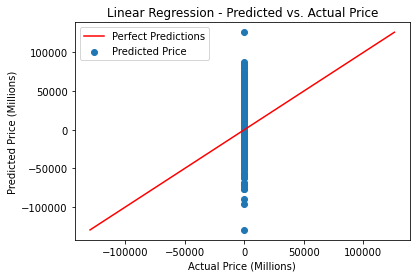

In [21]:
# Create a Linear Regression model
linear_model = LinearRegression()

# Train the model using the training data
linear_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = linear_model.predict(X_test)

# Evaluate the model's performance
linear_regression_mae = mean_absolute_error(y_test, y_pred)
linear_regression_mape = mean_absolute_percentage_error(y_test, y_pred)
linear_regression_mse = mean_squared_error(y_test, y_pred)
linear_regression_rmse = mean_squared_error(y_test, y_pred, squared=False)  
linear_regression_r2 = r2_score(y_test, y_pred)

y_test_millions = y_test / 1000000
y_pred_millions = y_pred / 1000000

# Scatter plot with prices in millions
plt.scatter(y_test_millions, y_pred_millions, label='Predicted Price')
plt.xlabel('Actual Price (Millions)')
plt.ylabel('Predicted Price (Millions)')
plt.title('Linear Regression - Predicted vs. Actual Price')
plt.legend()

# Diagonal line representing perfect predictions
min_val = min(min(y_test_millions), min(y_pred_millions))
max_val = max(max(y_test_millions), max(y_pred_millions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Perfect Predictions')
plt.legend()

plt.show()

# Random Forest

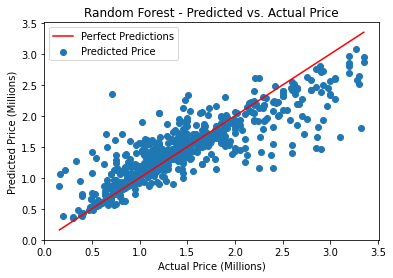

In [22]:
# Create a Random Forest Regression model with default hyperparameters
random_forest_model = RandomForestRegressor(random_state=42)

# Train the model using the training data
random_forest_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = random_forest_model.predict(X_test)

# Evaluate the model's performance
random_forest_mae = mean_absolute_error(y_test, y_pred)
random_forest_mape = mean_absolute_percentage_error(y_test, y_pred)
random_forest_mse = mean_squared_error(y_test, y_pred)
random_forest_rmse = mean_squared_error(y_test, y_pred, squared=False)  
random_forest_r2 = r2_score(y_test, y_pred)

y_test_millions = y_test / 1000000
y_pred_millions = y_pred / 1000000

# Scatter plot with prices in millions
plt.scatter(y_test_millions, y_pred_millions, label='Predicted Price')
plt.xlabel('Actual Price (Millions)')
plt.ylabel('Predicted Price (Millions)')
plt.title('Random Forest - Predicted vs. Actual Price')
plt.legend()

# Diagonal line representing perfect predictions
min_val = min(min(y_test_millions), min(y_pred_millions))
max_val = max(max(y_test_millions), max(y_pred_millions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Perfect Predictions')
plt.legend()

plt.show()

# Decison Trees

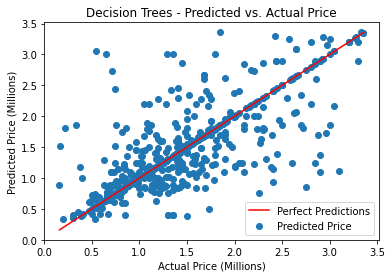

In [23]:
# Create a Decision Tree Regressor model
decision_tree_model = DecisionTreeRegressor()

# Train the model using the training data
decision_tree_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model's performance
decision_tree_mae = mean_absolute_error(y_test, y_pred)
decision_tree_mape = mean_absolute_percentage_error(y_test, y_pred)
decision_tree_mse = mean_squared_error(y_test, y_pred)
decision_tree_rmse = mean_squared_error(y_test, y_pred, squared=False)  
decision_tree_r2 = r2_score(y_test, y_pred)

y_test_millions = y_test / 1000000
y_pred_millions = y_pred / 1000000

# Scatter plot with prices in millions
plt.scatter(y_test_millions, y_pred_millions, label='Predicted Price')
plt.xlabel('Actual Price (Millions)')
plt.ylabel('Predicted Price (Millions)')
plt.title('Decision Trees - Predicted vs. Actual Price')
plt.legend()

# Diagonal line representing perfect predictions
min_val = min(min(y_test_millions), min(y_pred_millions))
max_val = max(max(y_test_millions), max(y_pred_millions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Perfect Predictions')
plt.legend()

plt.show()

# Gradient Boosting

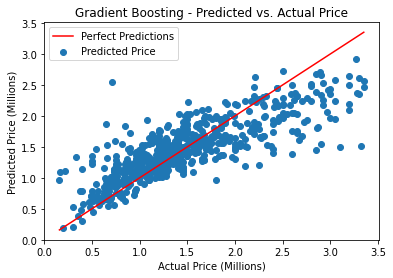

In [24]:
# Create the Gradient Boosting Regressor model
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model using the training data
gradient_boosting_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = gradient_boosting_model.predict(X_test)

# Evaluate the model's performance
gradient_boosting_mae = mean_absolute_error(y_test, y_pred)
gradient_boosting_mape = mean_absolute_percentage_error(y_test, y_pred)
gradient_boosting_mse = mean_squared_error(y_test, y_pred)
gradient_boosting_rmse = mean_squared_error(y_test, y_pred, squared=False)  
gradient_boosting_r2 = r2_score(y_test, y_pred)

y_test_millions = y_test / 1000000
y_pred_millions = y_pred / 1000000

# Scatter plot with prices in millions
plt.scatter(y_test_millions, y_pred_millions, label='Predicted Price')
plt.xlabel('Actual Price (Millions)')
plt.ylabel('Predicted Price (Millions)')
plt.title('Gradient Boosting - Predicted vs. Actual Price')
plt.legend()

# Diagonal line representing perfect predictions
min_val = min(min(y_test_millions), min(y_pred_millions))
max_val = max(max(y_test_millions), max(y_pred_millions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Perfect Predictions')
plt.legend()

plt.show()

# XGBoost

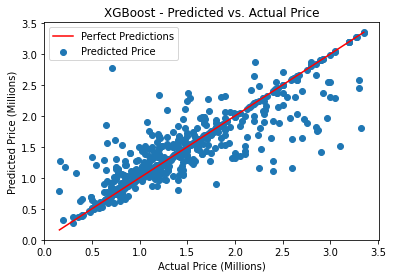

In [25]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'mae',            # Root Mean Squared Error (RMSE) as the evaluation metric
    'eta': 0.1,                       # Learning rate (try different values)
    'max_depth': 6,                   # Maximum depth of each tree (try different values)
    'subsample': 0.8,                 # Subsample ratio of the training instances (try different values)
    'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree (try different values)
    'seed': 42                        # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 1000  # Number of boosting rounds (try different values)
xgboost_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing set
y_pred = xgboost_model.predict(dtest)

# Evaluate the model's performance
xgboost_mae = mean_absolute_error(y_test, y_pred)
xgboost_mape = mean_absolute_percentage_error(y_test, y_pred)
xgboost_mse = mean_squared_error(y_test, y_pred)
xgboost_rmse = mean_squared_error(y_test, y_pred, squared=False)
xgboost_r2 = r2_score(y_test, y_pred)

y_test_millions = y_test / 1000000
y_pred_millions = y_pred / 1000000

# Scatter plot with prices in millions
plt.scatter(y_test_millions, y_pred_millions, label='Predicted Price')
plt.xlabel('Actual Price (Millions)')
plt.ylabel('Predicted Price (Millions)')
plt.title('XGBoost - Predicted vs. Actual Price')
plt.legend()

# Diagonal line representing perfect predictions
min_val = min(min(y_test_millions), min(y_pred_millions))
max_val = max(max(y_test_millions), max(y_pred_millions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Perfect Predictions')
plt.legend()

plt.show()

# Metrics

In [29]:
# Create lists to store the metrics and model names
models = ['Linear Regression', 'Decision Trees', 'Random Forest', 'Gradient Boosting', 'XGBoost']
mae_values = [linear_regression_mae, decision_tree_mae, random_forest_mae, gradient_boosting_mae, xgboost_mae]
mape_values = [linear_regression_mape, decision_tree_mape, random_forest_mape, gradient_boosting_mape, xgboost_mape]
mse_values = [linear_regression_mse, decision_tree_mse, random_forest_mse, gradient_boosting_mse, xgboost_mse]
rmse_values = [linear_regression_rmse, decision_tree_rmse, random_forest_rmse, gradient_boosting_rmse, xgboost_rmse]
r2_values = [linear_regression_r2, decision_tree_r2, random_forest_r2, gradient_boosting_r2, xgboost_r2]

# Display the metrics for each model
for i in range(len(models)):
    print("Model: ", models[i])
    print("MAE: ", mae_values[i])
    print("MAPE: ", mape_values[i])
    print("MSE: ", mse_values[i])
    print("RMSE: ", rmse_values[i])
    print("R-squared: ", r2_values[i])
    print("---------------------")

Model:  Linear Regression
MAE:  15270424649.000788
MAPE:  13628.677813941193
MSE:  6.931390294245325e+20
RMSE:  26327533675.30906
R-squared:  -1552385159.7139761
---------------------
Model:  Decision Trees
MAE:  252920.55121951218
MAPE:  0.2257556722684334
MSE:  217736486167.85855
RMSE:  466622.4235587683
R-squared:  0.512347630527146
---------------------
Model:  Random Forest
MAE:  230996.0096097561
MAPE:  0.19920624462205333
MSE:  119550408562.46088
RMSE:  345760.6232098457
R-squared:  0.7322495598556338
---------------------
Model:  Gradient Boosting
MAE:  287662.7356148592
MAPE:  0.24519067901750036
MSE:  155672371089.86832
RMSE:  394553.3818000656
R-squared:  0.6513491975575114
---------------------
Model:  XGBoost
MAE:  175590.39014227642
MAPE:  0.1571044863718401
MSE:  106024523502.71362
RMSE:  325614.0714138651
R-squared:  0.7625427367810585
---------------------


In [30]:
joblib.dump(xgboost_model, 'xgboost_model.pkl') 

['xgboost_model.pkl']